In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, m_e, c, h, k, epsilon_0, h, k, proton_mass
from scipy.special import kv  # Modified Bessel function of second kind

In [78]:
m_e_cgs = m_e * 1000
c_cgs = c * 100
e_cgs = e * c * 10
h_cgs = h * 1.e7
k_cgs = k * 1.e7
m_i_cgs = proton_mass * 1000

In [ ]:
# Constants in SPO
zeta = 0.2
gamp = 5/3
kappa = 0.13

# Functions
def RhRl(beta, Rh=40, Rl=1, betac=1, **kwargs):
    b = beta/betac
    bsq = b ** 2

    return (Rh * bsq / (bsq + 1) + Rl / (bsq + 1))

def PsPA(qshear):
    k_eff = 0.42 * np.sqrt(qshear * (4. - qshear)) / 2.
    gam_km = np.sqrt(np.sqrt((2. - qshear) * (2. - qshear) + 4 * k_eff * k_eff) - (k_eff * k_eff + (2. - qshear)))
    Ps_over_Pa = 0.5 * (qshear * (2. + 2. * (2. - qshear) / (k_eff * k_eff + gam_km * gam_km)) - 2.)

    return Ps_over_Pa

def get_f(beta, qshear):
    Ps_over_Pa = PsPA(qshear)
    f = Ps_over_Pa + 35./(1 + pow(beta/15., -1.4))

    return f

def SPO2023(beta, qshear=1.5, nR=1.5, betac=5, **kwargs):
    betasq = beta * beta/betac/betac
    f = get_f(beta, qshear)
    game = 4./3. + kappa * betasq / (1 + betasq)
    gamp_eff = 1. + 1. / ((1 + 2. * zeta / beta) / (gamp - 1.))
    trat = (gamp_eff - 1.) * (1. - (game - 1.) * (2. - nR)) * f / (game - 1.) / (1. - (gamp_eff - 1.) * (2. - nR) * (1. + 2. * zeta / beta))

    return trat

def get_gamp_eff(beta):
    gamp_eff = 1. + 1. / ((1 + 2. * zeta / beta) / (gamp - 1.))

    return gamp_eff

def get_Theta_e(trat, U=10, rho=10, betac=5):
    betasq = beta * beta/betac/betac
    if betac == 1:
        gamp_eff = gamp
        game = 4/3
    else:
        gamp_eff = get_gamp_eff(beta)
        game = 4./3. + kappa * betasq / (1 + betasq)

    return (m_i_cgs / m_e_cgs) * (game - 1) * (gamp_eff - 1) * U / ((gamp_eff - 1 + (game - 1) * trat) * rho)

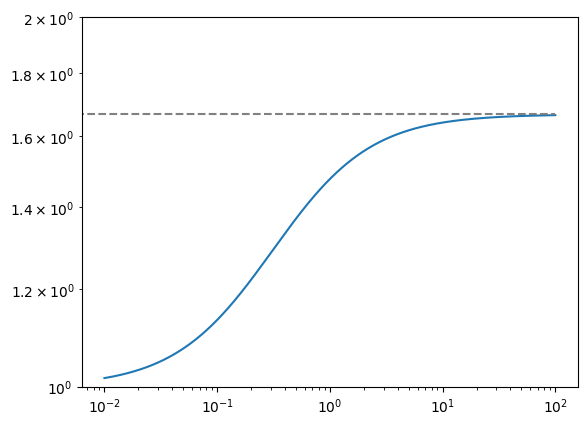

In [80]:
try:
    plt.loglog(beta, get_gamp_eff(beta))
    plt.hlines(gamp, -100, 100, 'gray', '--')
    plt.ylim(1, 2)
except:
    print("PASS")

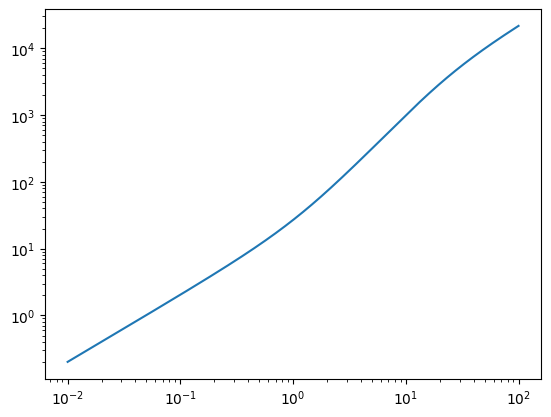

In [100]:
plt.loglog(beta, SPO_trat / np.abs(get_gamp_eff(beta) - gamp))

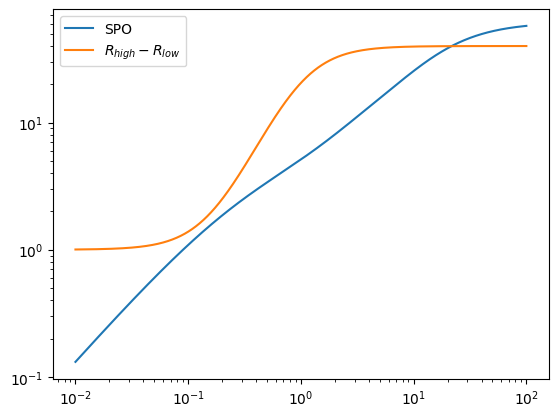

In [81]:
beta = np.logspace(-2, 2, 10000)
SPO_trat = SPO2023(beta)
RhRl_trat = RhRl(beta)
plt.loglog(beta, SPO_trat, label='SPO')
plt.loglog(beta, RhRl_trat, label=r'$R_{high}-R_{low}$')
plt.legend()

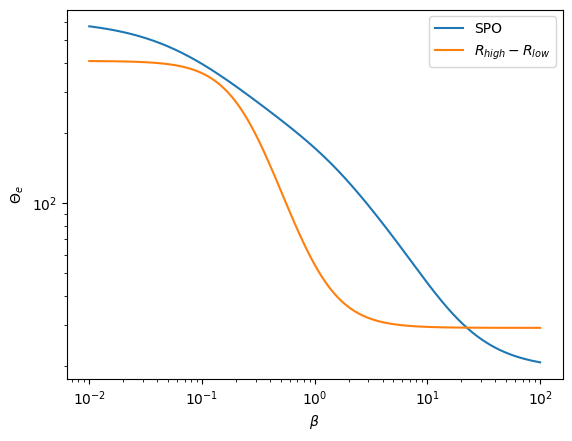

In [91]:
SPO_Theta_e = get_Theta_e(SPO_trat)
RhRl_Theta_e = get_Theta_e(RhRl_trat, betac=1)
plt.plot(beta, SPO_Theta_e, label='SPO')
plt.plot(beta, RhRl_Theta_e, label=r'$R_{high}-R_{low}$')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\Theta_e$')
plt.xlabel(r'$\beta$')
plt.legend()

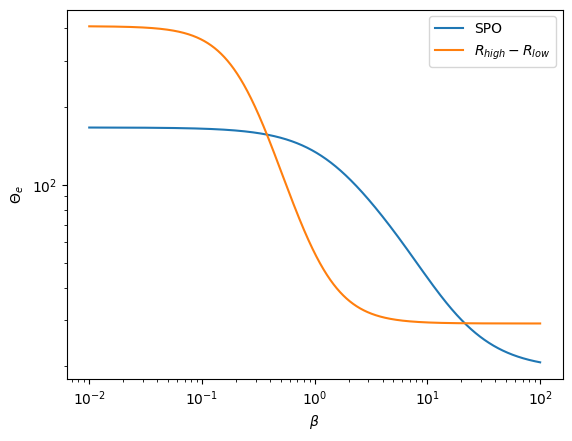

In [86]:
SPO_Theta_e = get_Theta_e(SPO_trat)
RhRl_Theta_e = get_Theta_e(RhRl_trat, betac=1)
plt.plot(beta, SPO_Theta_e, label='SPO')
plt.plot(beta, RhRl_Theta_e, label=r'$R_{high}-R_{low}$')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$\Theta_e$')
plt.xlabel(r'$\beta$')
plt.legend()

# Fitting Parameters

# One-zone Model

In [54]:
# Constants
B = 10 # [G]
nu_c = e_cgs * B / (2 * np.pi * m_e_cgs * c_cgs)
nu = 230.e9
Theta = np.deg2rad(30)

In [55]:
def get_nu_s(Theta_e):
    return (2/9) * nu_c * (Theta_e ** 2) * np.sin(Theta)

def get_j_nu(Theta_e): # per electron density
    K2 = kv(2, 1/Theta_e)
    nu_s = get_nu_s(Theta_e)
    X = nu / nu_s

    numerator = np.sqrt(2) * np.pi * (e_cgs ** 2) * nu_s
    denominator = 3 * K2 * c_cgs
    prefactor = numerator / denominator
    factor = np.exp(-X**(1/3)) * (np.power(X, 1/2) + np.power(2, 11/12) * np.power(X, 1/6)) ** 2
    return np.log10(factor * prefactor)

def maxwell_dist(Theta_e):
    kT_e = Theta_e * m_e_cgs * (c_cgs ** 2)
    exp_power = h_cgs * nu / kT_e
    prefactor = 2 * h_cgs * (nu ** 3) / (c_cgs ** 2)
    return prefactor / (np.exp(exp_power) - 1)

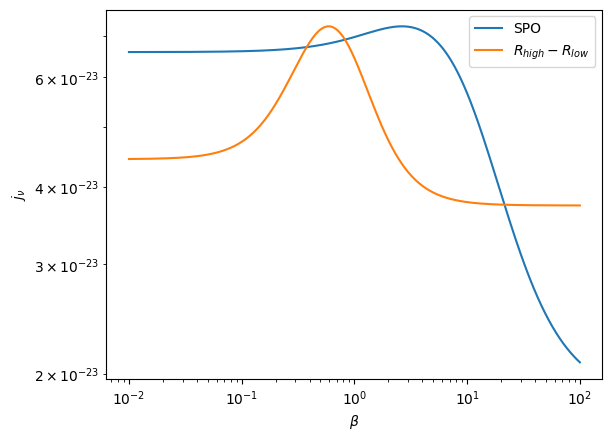

In [56]:
SPO_j_nu = get_j_nu(SPO_Theta_e)
SPO_alpha = (10 ** SPO_j_nu) / maxwell_dist(SPO_Theta_e)

RhRl_j_nu = get_j_nu(RhRl_Theta_e)
RhRl_alpha = (10 ** RhRl_j_nu) / maxwell_dist(RhRl_Theta_e)

plt.plot(beta, 10 ** SPO_j_nu, label=r'SPO')
plt.plot(beta, 10 **RhRl_j_nu, label=r'$R_{high}-R_{low}$')
plt.xlabel(r'${\beta}$')
plt.ylabel(r"$j_\nu$")
plt.xscale('log')
plt.yscale('log')
plt.legend()

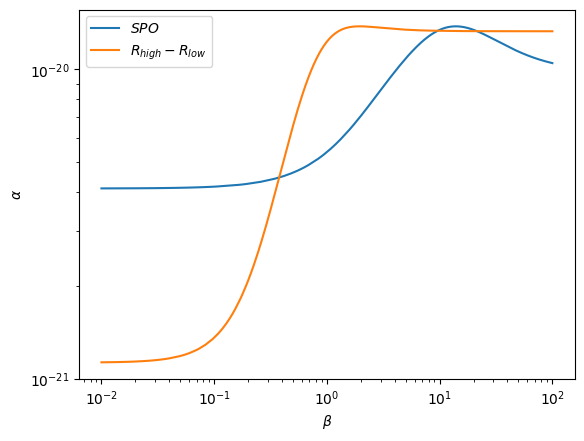

In [57]:
plt.plot(beta, SPO_alpha, label=r'$SPO$')
plt.plot(beta, RhRl_alpha, label=r'$R_{high}-R_{low}$')
plt.ylabel(r'${\alpha}$')
plt.xlabel(r'$\beta$')
plt.legend()
plt.xscale('log')
plt.yscale('log')

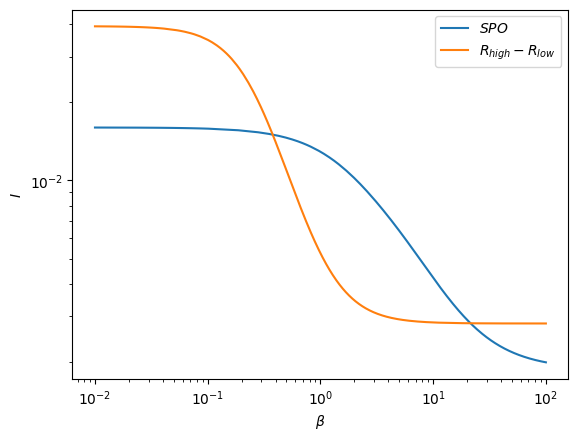

In [58]:
plt.plot(beta, 10 ** SPO_j_nu/SPO_alpha, label=r'$SPO$')
plt.plot(beta, 10 ** RhRl_j_nu/RhRl_alpha, label=r'$R_{high}-R_{low}$')
plt.ylabel(r'${I}$')
plt.xlabel(r'$\beta$')
plt.legend()
plt.xscale('log')
plt.yscale('log')

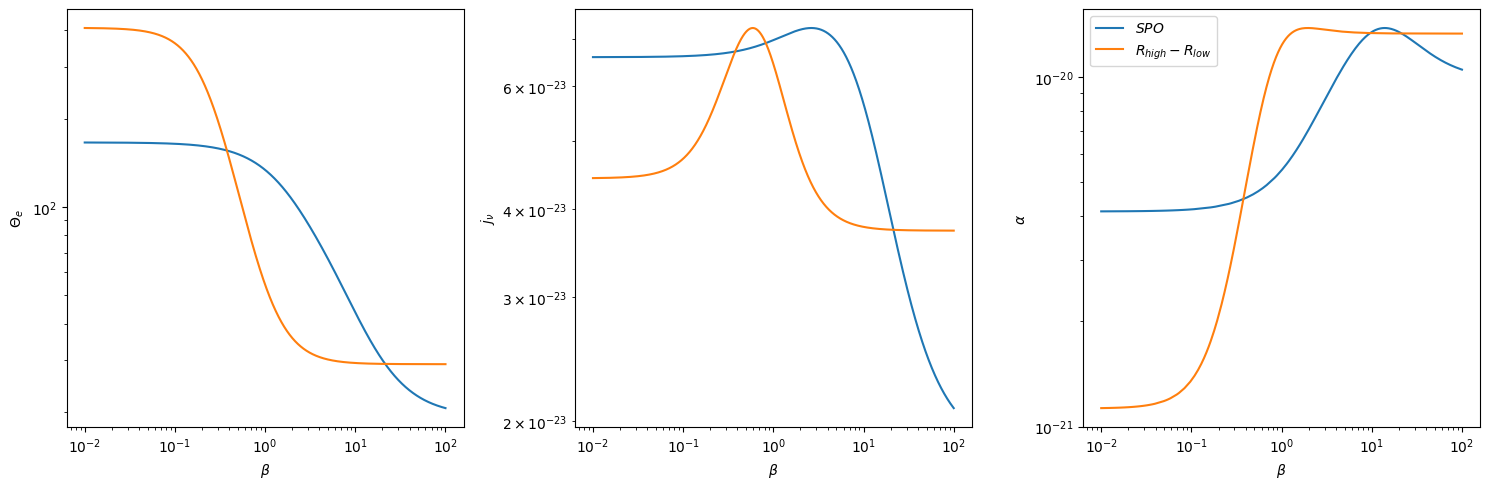

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].loglog(beta, SPO_Theta_e, label='SPO')
ax[0].loglog(beta, RhRl_Theta_e, label=r'$R_{high}-R_{low}$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r"$\Theta_e$")

ax[1].loglog(beta, 10 ** SPO_j_nu, label=r'SPO')
ax[1].loglog(beta, 10 **RhRl_j_nu, label=r'$R_{high}-R_{low}$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r"$j_\nu$")

ax[2].loglog(beta, SPO_alpha, label=r'$SPO$')
ax[2].loglog(beta, RhRl_alpha, label=r'$R_{high}-R_{low}$')
ax[2].set_xlabel(r'$\beta$')
ax[2].set_ylabel(r"$\alpha$")

plt.legend()
plt.tight_layout()

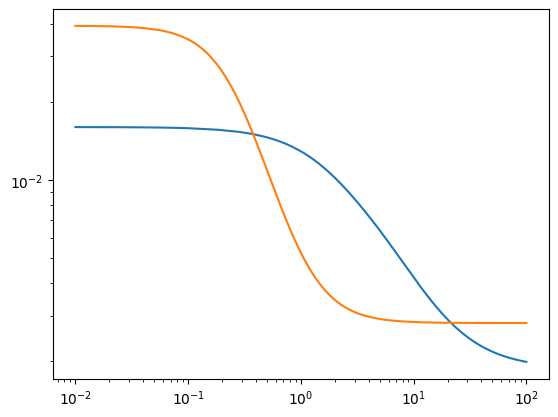

In [60]:
plt.loglog(beta, 10 ** SPO_j_nu / SPO_alpha)
plt.loglog(beta, 10 ** RhRl_j_nu / RhRl_alpha)

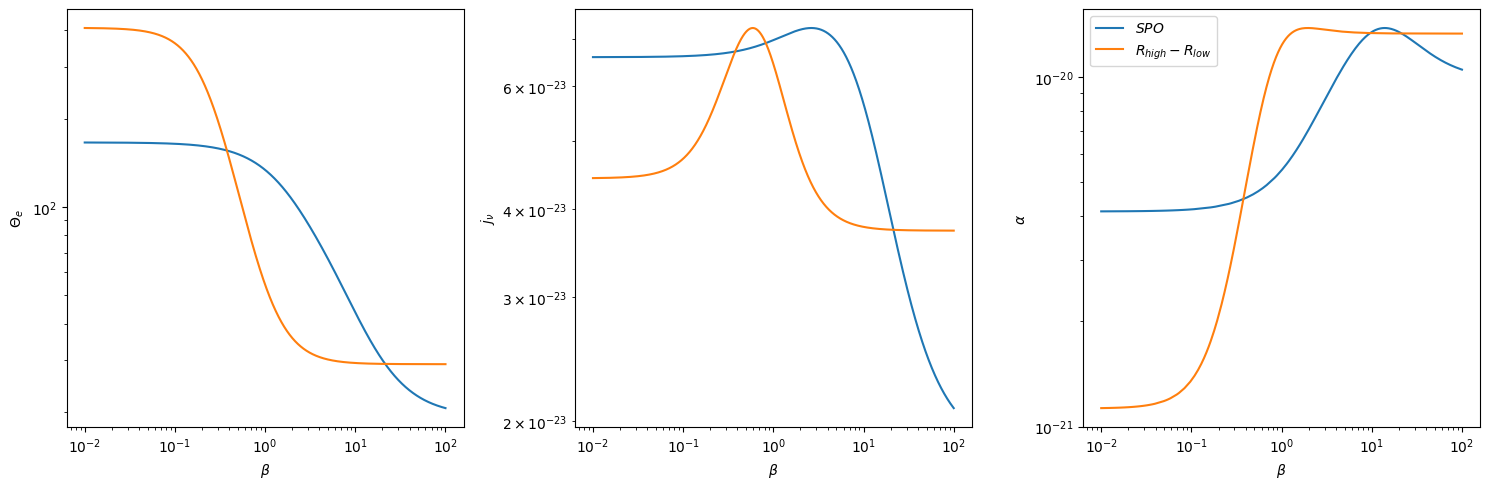

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].loglog(beta, SPO_Theta_e, label='SPO')
ax[0].loglog(beta, RhRl_Theta_e, label=r'$R_{high}-R_{low}$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r"$\Theta_e$")

ax[1].loglog(beta, 10 ** SPO_j_nu, label=r'SPO')
ax[1].loglog(beta, 10 **RhRl_j_nu, label=r'$R_{high}-R_{low}$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r"$j_\nu$")

ax[2].loglog(beta, SPO_alpha, label=r'$SPO$')
ax[2].loglog(beta, RhRl_alpha, label=r'$R_{high}-R_{low}$')
ax[2].set_xlabel(r'$\beta$')
ax[2].set_ylabel(r"$\alpha$")

plt.legend()
plt.tight_layout()

@ARTICLE{2011ApJ...737...21L,
       author = {{Leung}, Po Kin and {Gammie}, Charles F. and {Noble}, Scott C.},
        title = "{Numerical Calculation of Magnetobremsstrahlung Emission and Absorption Coefficients}",
      journal = {\apj},
     keywords = {methods: numerical, radiation mechanisms: general},
         year = 2011,
        month = aug,
       volume = {737},
       number = {1},
          eid = {21},
        pages = {21},
     abstract = "{Magnetobremsstrahlung (MBS) emission and absorption play a role in many
        astronomical systems. We describe a general numerical scheme for
        evaluating MBS emission and absorption coefficients for both
        polarized and unpolarized light in a plasma with a general
        distribution function. Along the way we provide an accurate
        scheme for evaluating Bessel functions of high order. We use our
        scheme to evaluate the accuracy of earlier fitting formulae and
        approximations. We also provide an accurate fitting formula for
        mildly relativistic (kT/(m$_{e}$c $^{2}$)
        >\raisebox{-0.5ex}\textasciitilde 0.5) thermal electron emission
        (and therefore absorption). Our scheme is too slow, at present,
        for direct use in radiative transfer calculations but will be
        useful for anyone seeking to fit emission or absorption
        coefficients in a particular regime.}",
          doi = {10.1088/0004-637X/737/1/21},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2011ApJ...737...21L},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}
@ARTICLE{2016ApJ...822...34P,
       author = {{Pandya}, Alex and {Zhang}, Zhaowei and {Chandra}, Mani and {Gammie}, Charles F.},
        title = "{Polarized Synchrotron Emissivities and Absorptivities for Relativistic Thermal, Power-law, and Kappa Distribution Functions}",
      journal = {\apj},
     keywords = {plasmas, polarization, radiation mechanisms: general, radiative transfer, relativistic processes, Astrophysics - High Energy Astrophysical Phenomena},
         year = 2016,
        month = may,
       volume = {822},
       number = {1},
          eid = {34},
        pages = {34},
     abstract = "{Synchrotron emission and absorption determine the observational
        appearances of many astronomical systems. In this paper, we
        describe a numerical scheme for calculating synchrotron
        emissivities and absorptivities in all four Stokes parameters
        for arbitrary gyrotropic electron distribution functions,
        building on earlier work by Leung, Gammie, and Noble. We use
        this technique to evaluate the emissivities and the
        absorptivities for a thermal (Maxwell-J{\"u}ttner), isotropic
        power-law, and an isotropic kappa distribution function. The
        latter contains a power-law tail at high particle energies that
        smoothly merges with a thermal core at low energies, as is
        characteristic of observed particle spectra in collisionless
        plasmas. We provide fitting formulae and error bounds on the
        fitting formulae for use in codes that solve the radiative
        transfer equation. The numerical method and the fitting formulae
        are implemented in a compact C library called symphony. We find
        that the kappa distribution has a source function that is
        indistinguishable from a thermal spectrum at low frequency and
        transitions to the characteristic self-absorbed synchrotron
        spectrum, \textbackslashpropto \{{\ensuremath{\nu}} \}$^{5/2}$,
        at high frequency; the linear polarization fraction for a
        thermal spectrum is near unity at high frequency; and all
        distributions produce O(10\%) circular polarization at low
        frequency for lines of sight sufficiently close to the magnetic
        field vector.}",
          doi = {10.3847/0004-637X/822/1/34},
archivePrefix = {arXiv},
       eprint = {1602.08749},
 primaryClass = {astro-ph.HE},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2016ApJ...822...34P},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

To analyze the effect of the \SPO images, we first derive the 
theoretical expectation from the \SPO model. By assuming constant
$U=10$, $\rho=10$, we plot the electron temperature, emissivity,
absorptivity following Eq~\ref{eq:Theta_e} and
~\cite{2011ApJ...737...21L, 2016ApJ...822...34P}. To account for 
the turbulence effect in \SPO model, we also substitute the
$\gamma_i$ to $\gamma_i^{eff}$, while keeping $\gamma_i=5/3$ 
in $\Rl-\Rh$ model for in Equation~\ref{eq:Theta_e}. The results
are shown in Figure~\ref{fig:one-zone}.

We first assess the behaviour of electron tempearture in 
low $\beta$ region.
Although $T_i/T_e<1$ in \SPO model during low-$\beta$ limit,
its electron temperature is still lower than that of
$\Rl-\Rh$ model. This is a direct consequence of including turbulence
effect in $\gamma_i^{eff}$ in Equation \ref{eq:Theta_e}.
Physically, as the plasma is magnetically dominated in low $\beta$ limit, 
ions in plasma does not act like a monoatomic gas. This behaviour
is captured by the $\gamma_i^{eff}$, where $\gamma_i^{eff}\approx 1$
in low $\beta$ limit. \TODO{how does this reduce the electron 
temperature}? The high electron temperature of $\Rl-\Rh$ shifts the 
spectrum to higher frequency, making \SPO model have higher 
emissivity and lower absorptivity in the low $\beta$ region.
At $\beta$ increases, the collisionless damping takes the main role,
reducing the energy partition towards electrons. This results in the 
low emissivity and high absorptivitiy in \SPO model. 

In [62]:
def get_tau_nu(alpha_nu, s):
    return alpha_nu * s
    
def get_I_nu(j_nu, alpha_nu, s=10):
    S_nu = (10 ** j_nu) / alpha_nu
    tau_nu = get_tau_nu(alpha_nu, s)

    return S_nu * (1 - np.exp(- tau_nu))